First few rows of the dataset:
                  Ex_rate
date                     
01-01-1990 00:00   0.7855
02-01-1990 00:00   0.7818
03-01-1990 00:00   0.7867
04-01-1990 00:00   0.7860
05-01-1990 00:00   0.7849

Column names:
Index(['Ex_rate'], dtype='object')


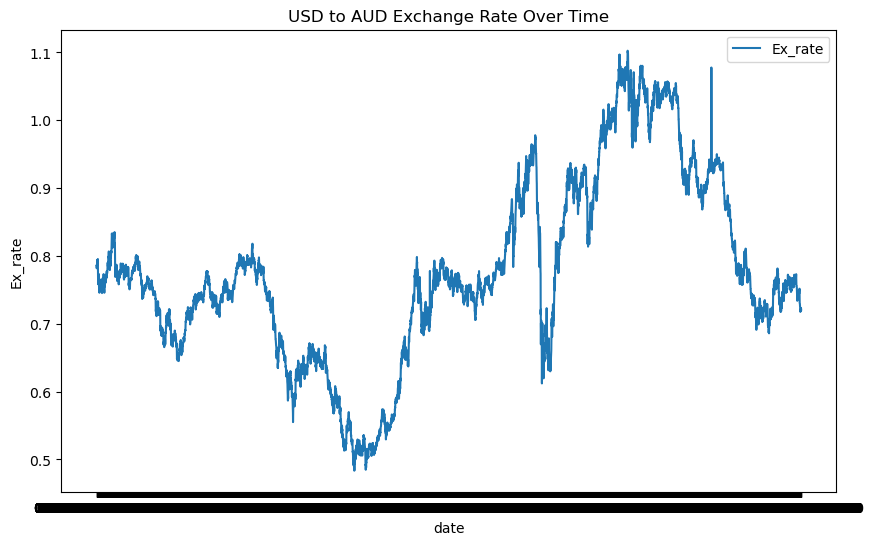

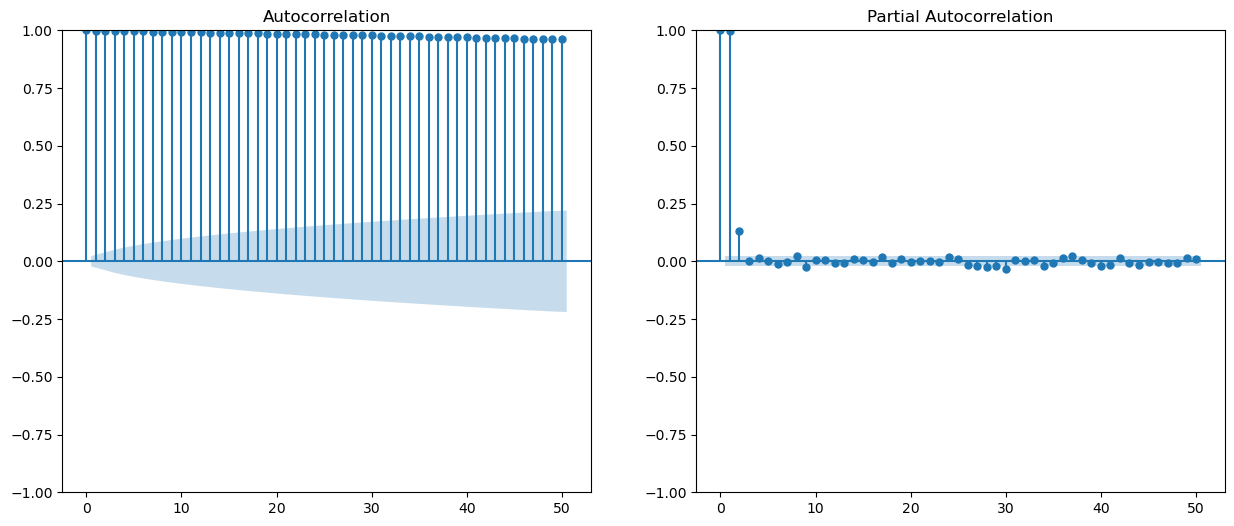

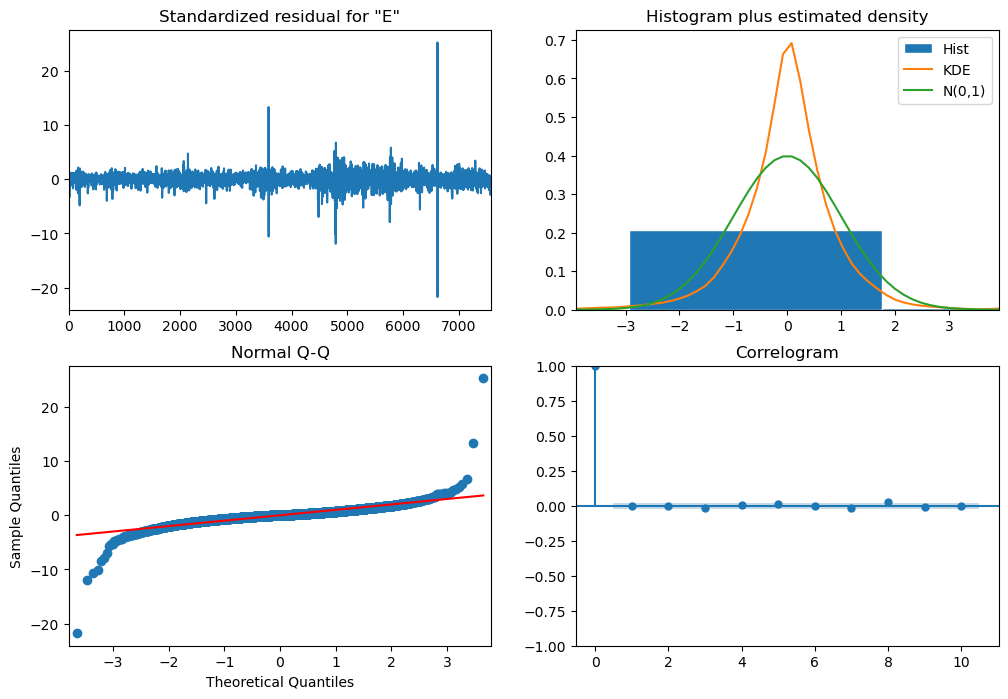

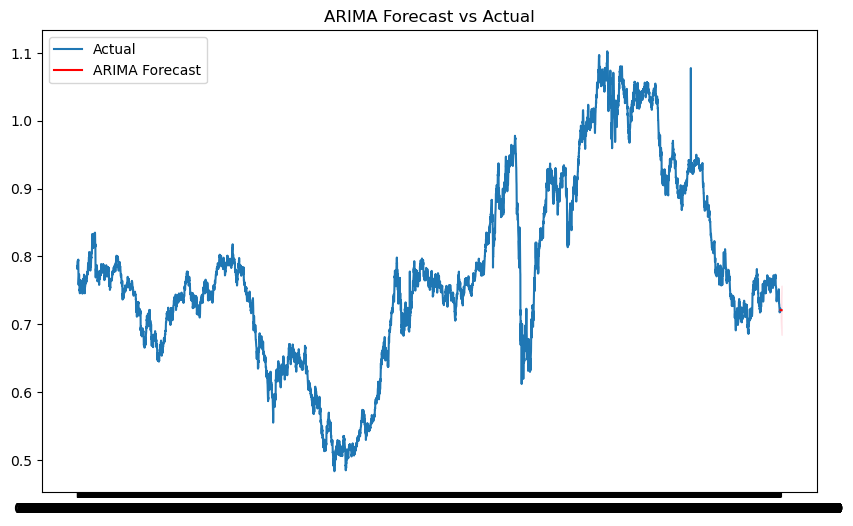

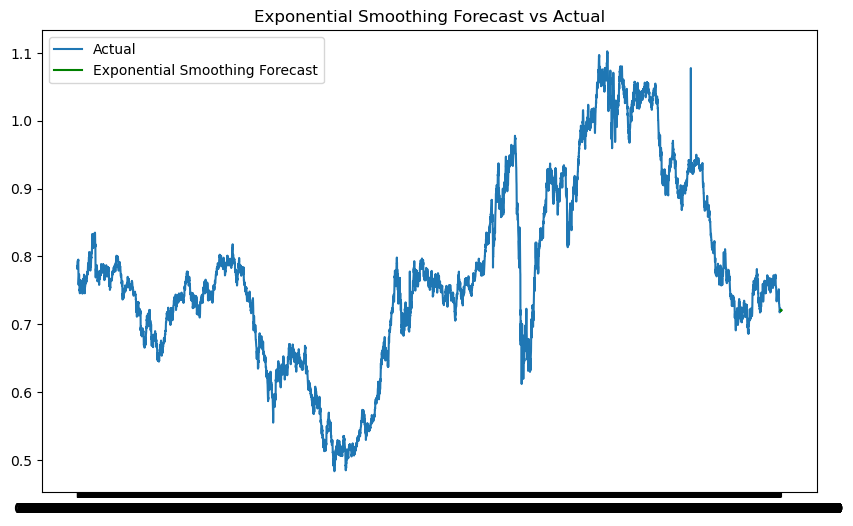

ARIMA - MAE: 0.001664492434046964, MSE: 4.001432422041692e-06, RMSE: 0.002000358073456273
Exponential Smoothing - MAE: 0.0015805480762200175, MSE: 3.4737808257818947e-06, RMSE: 0.0018638081515493742
Exponential Smoothing model performed better.


In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

warnings.filterwarnings('ignore')

# Step 1: Load the dataset and check its structure
df = pd.read_csv('exchange_rate.csv', parse_dates=['date'], index_col='date')

# Check the first few rows and the column names
print("First few rows of the dataset:")
print(df.head())
print("\nColumn names:")
print(df.columns)

# Step 2: Update the exchange rate column name based on the dataset inspection
exchange_rate_column = 'Ex_rate'  # Replace this with the actual column name after inspection

# Part 1: Data Preparation and Exploration
# Initial exploration: Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(df[exchange_rate_column], label='Ex_rate')
plt.title('USD to AUD Exchange Rate Over Time')
plt.xlabel('date')
plt.ylabel('Ex_rate')
plt.legend()
plt.show()

# Handling missing values (if any)
df = df.fillna(method='ffill')

# Part 2: Model Building - ARIMA
# Plot ACF and PACF to select ARIMA parameters
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
plot_acf(df[exchange_rate_column], lags=50, ax=axes[0])
plot_pacf(df[exchange_rate_column], lags=50, ax=axes[1])
plt.show()

# Select p, d, q based on the plots
p = 1  # Chosen based on PACF
d = 1  # Time series is non-stationary, hence differencing
q = 1  # Chosen based on ACF

# Fit the ARIMA model
arima_model = SARIMAX(df[exchange_rate_column], order=(p, d, q), seasonal_order=(0, 0, 0, 0))
arima_result = arima_model.fit()

# Diagnostics
arima_result.plot_diagnostics(figsize=(12, 8))
plt.show()

# Forecasting using ARIMA
forecast_arima = arima_result.get_forecast(steps=12)
forecast_arima_ci = forecast_arima.conf_int()

plt.figure(figsize=(10, 6))
plt.plot(df[exchange_rate_column], label='Actual')
plt.plot(forecast_arima.predicted_mean, label='ARIMA Forecast', color='red')
plt.fill_between(forecast_arima_ci.index, forecast_arima_ci.iloc[:, 0], forecast_arima_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('ARIMA Forecast vs Actual')
plt.legend()
plt.show()

# Part 3: Model Building - Exponential Smoothing
# Fit Holt-Winters model (Triple Exponential Smoothing)
es_model = ExponentialSmoothing(df[exchange_rate_column], seasonal_periods=12, trend='add', seasonal='add').fit()

# Forecasting using Exponential Smoothing
forecast_es = es_model.forecast(steps=12)

plt.figure(figsize=(10, 6))
plt.plot(df[exchange_rate_column], label='Actual')
plt.plot(forecast_es, label='Exponential Smoothing Forecast', color='green')
plt.title('Exponential Smoothing Forecast vs Actual')
plt.legend()
plt.show()

# Part 4: Evaluation and Comparison
# Calculate error metrics
def calculate_metrics(true_values, predicted_values):
    mae = mean_absolute_error(true_values, predicted_values)
    mse = mean_squared_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

# Split data into train and test sets for evaluation
train = df[exchange_rate_column][:-12]
test = df[exchange_rate_column][-12:]

# ARIMA Error Metrics
arima_forecast_test = arima_result.get_forecast(steps=12).predicted_mean
mae_arima, mse_arima, rmse_arima = calculate_metrics(test, arima_forecast_test)

# Exponential Smoothing Error Metrics
es_forecast_test = es_model.forecast(steps=12)
mae_es, mse_es, rmse_es = calculate_metrics(test, es_forecast_test)

# Compare the models
print(f"ARIMA - MAE: {mae_arima}, MSE: {mse_arima}, RMSE: {rmse_arima}")
print(f"Exponential Smoothing - MAE: {mae_es}, MSE: {mse_es}, RMSE: {rmse_es}")

# Conclusion based on error metrics
if rmse_arima < rmse_es:
    print("ARIMA model performed better.")
else:
    print("Exponential Smoothing model performed better.")
